# PSU DS 200 
# Lab 5 Train and Interpret Decision Trees Model: NFL Pass Completion Prediction
## Learning Objectives 

In this lab, you will learn to be able to do the following:
- Learn a decision tree model for binary classification/prediction using a set of training data.
    * The binary classification problem of this lab is predicting whether a pass by a quaterback in an NFL game completes or not.
    * The source of the data is Kaggle, which provides a broad variety of real-world data for various competitions.
-  You will learn to split a set of labelled data (labelled with desired prediction output, i.e., pass complete or incomplete) into two groups: (1) those data to be used to "train" the model, and (2) those data to be used to test how well the model can predict.
- Evaluate how good is the model (for prediction) 
    * Predictive Models need to be evaluated using data NOT used for constructing (training) the model.
- Interpret the model to understand the "logic" learned from data

In [1]:
import numpy as np
import pandas as pd
import graphviz

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

## Reading Data for Constructing a Predictive Model
### Format of the Data
Data for constructing a predictive model is often stored in a "Comma-Separated Values" format, also commonly referred to as "CSV" format.  A file that stores data in CSV format uses ".csv" as its file extension.  

### Read_CSV in Panda
The easiest way to read a CSV file for the purpose of constructing a predictive model is to use read_csv function in Panda. The function reads data from a CSV file, and generates a table-style internal representation (called DataFrame).
<ul>
    <li> The first parameter of the function is the name of the csv file to be read. </li>

    <li> The "sep=" parameter in read_csv specifieds the separator of different fields.  Because the CSV file used for this lab uses comma (i.e., ",") as separator, the read_csv function has "sep="," as the second pamater. </li>
    
</ul>

In [4]:
Ben_pass= pd.read_csv('Ben-NE-9-10-2015-pass-6.csv', sep=",")

### Display the Data 
The first row of the CSV file contains the names of attributes/features for each passing play of a specific NFL game (between Pittsburgh Steelers and New England Patriots held on September 10th, 2015).  Because pass prediction model for each quaterback can be different, so this dataset is prepared for the purpose of predicting the outcome of passing play by Steeler quaterback Ben Rothlisberger. The last column of the CSV file contains the outcome of each passing play.

In general, the data for building a predictive model involves two types: 
<ol>
    <li> The input data to the model (which we also call FEATURES), and </li>
    <li> The DESIRED prediction output data of the model (for each corresponding input) </li>
    </ol>
Together, these data are used to "train" the model, as we shall see later, so that the model's output,
given each input, is AS CLOSE AS POSSIBLE (we will elaborate this point later) to the DESIRED output.

For example, the data for training to predict pass completion includes input data for the prediction (e.g., distance of pass, number of down, yards to go, etc), and the DESIRED output of the prediction (i.e., whether a pass plays completes or not). 

The meaning of all the input attributes/features for this lab are listed below:
<ul>
    <li>down: The number of down for the play</li>
    <li>ydstogo: The remaining yards needed to gain for a first down</li>
    <li>Yards.Gained.PrevPlay: The number of yards gained in the previous play (which can be a run play or passing play}</li>
    <li>AirYards: The distance between the starting position of the play and the receiving position of the passing play. A negative number means the quarterback moves back in the play such that the net yardage gain, if the pass completes, is negative. </li>
    <li>PassLocation: The area of passing location: -1 means left field, 0 means center field, 1 means right field. </li>
</ul>

The value of the desired prediction output (i.e., PassOutcome in the last column) in the dataset indicates whether the outcome of each passing play, represented by each row, is completes (i.e., having the value "1") or incomplete (i.e., having the value "0").  

In [5]:
print(Ben_pass)

    down  ydstogo  Yards.Gained.PrevPlay  AirYards  PassLocation  PassOutcome
0      1       10                     18        -4             1            1
1      1       10                      0         9             1            1
2      3       22                      6         1             1            1
3      1       10                      0         7            -1            1
4      1       10                     13         6            -1            1
5      1       10                     12         7            -1            1
6      1       10                      0         5             1            0
7      2       10                      0        25             1            0
8      3        5                     -1         6            -1            1
9      1       15                      4        -1             1            1
10     3       18                     -6        17            -1            1
11     1       20                      5         5            -1

## Prepare Labelled Data for Model Training
In order to use the data to train a predictitive model, we need to extract the input data and corresponding output data from the table-like internal representation (i.e., DataFrame) generated by Panda read_csv function (and subsequentenly assigned to the variable Ben_pass).  

One easy way to do this is to use .values method (of DataFrame) to 
<ol>
    <li> Extract values from the columns for the input data and assign it to a variable (e.g., "X" in the code below), and </li>
    <li> Extract values from the column for the DESIRED output data and assigned to a different variable (e.g., "Y" in the code below).</li>
</ol>

### Prepare Input Data for Model Training

We want to use the following five attributes as inputs for predicting pass completion:
<ul>
    <li> down: The number of down for the play </li>
    <li> ydstogo: The remaining yards needed to gain for a first down </li>
<li> Yards.Gained.PrevPlay: The number of yards gained in the previous play (which can be a run play or passing play} </li>
<li> AirYards: The distance between the starting position of the play and the receiving position of the passing play. A negative number means the quarterback moves back in the play such that the net yardage gain, if the pass completes, is negative. </li>
<li>PassLocation: The area of passing location: -1 means left field, 0 means center field, 1 means right field.</li>
    </ul>

In DataFrame, the first column is referred to as column "0" (rather than column 1).  Therefore, the columns of the table-like representation stored in Ben_pass are:
<ul>
    <li> The column
        storing the value of "down" is column 0. </li>
    <li> The column storing the value of "ydstogo" is column 1. </li>
    <li> The column storing the value of "Yards.Gained.PrevPlay" is column 2. </li>
    <li> The column storing the value of "AirYards" is column 3. </li>
    <li> The column storing the value of "PassLocation" is column 4. </li>
    <li> The column storing the value of desired model output "PassOutcome" is column 5. </li>
    </ul>

To extract column 0, 1, 2, and 3 from Ben_pass (which stores the table-like representation), we use "0:4" to indicate a range of columns from column 0 to (but NOT including) column 4.  The method we use to extract these columns is "values".  The first parameter of values (colon, ":"), indicates that we are extracting ALL Rows.  Together with the second parameter "0:4", the method values[:, 0:4] indicates we are extracting column 0 to column 4 for all rows of the table-like representation stored in Ben_pass.  

We store the extracted input data in a variable called X.

#### Notice that we do not want to extract column 5 because it contains the desired model output, so we want to save it in a different variable to prepare for model training (which takes model input data and desired model output data separately).

In [6]:
X= Ben_pass.values[:,0:4]
print(X)

[[ 1 10 18 -4]
 [ 1 10  0  9]
 [ 3 22  6  1]
 [ 1 10  0  7]
 [ 1 10 13  6]
 [ 1 10 12  7]
 [ 1 10  0  5]
 [ 2 10  0 25]
 [ 3  5 -1  6]
 [ 1 15  4 -1]
 [ 3 18 -6 17]
 [ 1 20  5  5]
 [ 2 11  9  4]
 [ 2 13 -3 -2]
 [ 3  6  7  6]
 [ 2  7  0 11]
 [ 1 10 13 16]
 [ 1 10 19  6]
 [ 2  8  2  0]
 [ 3  8  0 39]
 [ 3  3  1 19]
 [ 1 10  0 11]
 [ 2 10  0 17]
 [ 1 10 18  7]
 [ 1  9  2  4]
 [ 2  6  3  6]
 [ 1 10  0  5]
 [ 2 15  9  4]
 [ 3  6  9 26]
 [ 2  8  2  0]
 [ 3  3  5 23]
 [ 4  3  0  4]
 [ 2  5  5 26]
 [ 3  5  0  7]
 [ 1 10  0  4]
 [ 3  5  1  5]
 [ 2  1  9 -1]
 [ 2  1  0  0]
 [ 1 10 28 23]
 [ 1 10 13 -5]
 [ 2 15 -5  7]
 [ 3  6 -1  2]
 [ 1 10  0 25]
 [ 2  5  5  2]
 [ 2  8  0  1]
 [ 1  1  0  1]
 [ 1 10  0 18]
 [ 1 10  0 27]
 [ 3  5  5  4]
 [ 2  1  0  1]
 [ 3  1  0  1]
 [ 2  3  7  9]
 [ 3  3  0  9]
 [ 2 12 -2 23]
 [ 3 12  0  6]
 [ 1 10  0 18]
 [ 1 10 18 39]
 [ 2  9  1  7]
 [ 3  4  3 -3]
 [ 1 10  0 11]
 [ 2 10  0  4]
 [ 3  1  9  6]
 [ 1 10  0 29]
 [ 2 10  0  1]
 [ 3  8  2 13]
 [ 2 27 -7 14]
 [ 3  9  0

As we can see from the result of print (X) above, X is actually an array.

### Exercise 1 (4 points)

The previous code only extract the first 4 features of each passing event. However, we want to extract all 5 input features of each passing event. Modify the code so that it extracts all 5 features of each passing event from Ben_pass.  Print the data you extract to see whether they are correct. 

In [7]:
X1 = Ben_pass.values[:,0:5]
print(X1)

[[ 1 10 18 -4  1]
 [ 1 10  0  9  1]
 [ 3 22  6  1  1]
 [ 1 10  0  7 -1]
 [ 1 10 13  6 -1]
 [ 1 10 12  7 -1]
 [ 1 10  0  5  1]
 [ 2 10  0 25  1]
 [ 3  5 -1  6 -1]
 [ 1 15  4 -1  1]
 [ 3 18 -6 17 -1]
 [ 1 20  5  5 -1]
 [ 2 11  9  4 -1]
 [ 2 13 -3 -2 -1]
 [ 3  6  7  6  0]
 [ 2  7  0 11  1]
 [ 1 10 13 16  1]
 [ 1 10 19  6  1]
 [ 2  8  2  0 -1]
 [ 3  8  0 39 -1]
 [ 3  3  1 19  1]
 [ 1 10  0 11  0]
 [ 2 10  0 17 -1]
 [ 1 10 18  7  0]
 [ 1  9  2  4 -1]
 [ 2  6  3  6  0]
 [ 1 10  0  5  1]
 [ 2 15  9  4 -1]
 [ 3  6  9 26  1]
 [ 2  8  2  0 -1]
 [ 3  3  5 23  1]
 [ 4  3  0  4  0]
 [ 2  5  5 26 -1]
 [ 3  5  0  7  0]
 [ 1 10  0  4  1]
 [ 3  5  1  5  1]
 [ 2  1  9 -1 -1]
 [ 2  1  0  0 -1]
 [ 1 10 28 23 -1]
 [ 1 10 13 -5 -1]
 [ 2 15 -5  7  0]
 [ 3  6 -1  2 -1]
 [ 1 10  0 25  1]
 [ 2  5  5  2  1]
 [ 2  8  0  1  1]
 [ 1  1  0  1  0]
 [ 1 10  0 18  1]
 [ 1 10  0 27  0]
 [ 3  5  5  4  0]
 [ 2  1  0  1  1]
 [ 3  1  0  1 -1]
 [ 2  3  7  9  0]
 [ 3  3  0  9  1]
 [ 2 12 -2 23  1]
 [ 3 12  0  6  0]
 [ 1 10  0

#### Notice: The variable used in the exercise is different from X.  
This is important because once a variable (like X) is assigned a new value, it losts its original value.  Because we will use variable X in the rest of this lab, we do NOT want to change the value of X.  Therefore, you can use variables  such as X1 or any other variables EXCEPT X in the exercise.

### Self-evaluation of Exercise 1
How did you do? 
You can also change your code to extract columns 0, 1, and 2; or to extract columns 2, 3, and 4. 

### Prepare Output Data for Model Training
To prepare desired output data (also referred to as target output data) for model training, we extract PassOutcome, which is stored in column 5 of Ben_pass table-like representation.  Similar to the previous step, we extract this data from ALL ROWS of the Ben_pass table-like representation. 

We store this output data in a variable Y.

In [8]:
Y= Ben_pass.values[:,5]
print(Y)

[1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1]


As we can see from the result of print(Y), Y is a one-dimensional array.  

##### Train a Decision Tree from a Set of Training Data

### We will use Python scikit-learn module to create a decision tree.
### Scikit-learn offers other machine learning models beyond decision trees.
### We do not need to install scikit-learn, because it has been pre-installed in Azure Notebooks (together with Python 3)
Scikit-learn (sklearn) is a Python module that contains many useful machine learning code, including code for constructing model from data, for creating predictive models using multiple machine learning methods (including decision tree which we will use), and for evaluating how good is the model created.  

### In the beginning of this notebook, we used the following import statement to import a submodule of scikit-learn (sklearn), tree (which provides functions/methods related to decision trees)
    from sklearn import tree

### Split the Data into Training Set and Testing Set using Train_Test_Split in sklearn
It is important that we reserve some data to evaluate how good is the prediction capability of the model.  This means that we are NOT going to use this reserved data to train the model.  THIS IS A VERY IMPORTANT POINT and we will return to it later for a more detail look.  For now, we will focus on the workflow for constructing a predictive model.

There are multiple ways to use data to train decision tree models.  We will use train_test_split Python command from sklearn Python module. In the beginning of this lab, we have imported train_test_split from sklearn as follows:

    from sklearn.model_selection import train_test_split

Importing a function from a library means we can directly use this function after the import.

Train_test_split has four parameters:
<ol>
    <li> The first paraemter is all of the model's input data. We have prepared variable X1 to be used here. </li>
    <li> The second parameter is all of the model's target output data.  We have prepared variable Y to be used here. </li>
    <li> The third parameter (test_size) is the percentage of the data (both model input and output) to be RESERVED for testing.  We use 25% here, and will revisit this topic later. </li>
    <li> The fourth paraemter (randome_state) is a random number to be used to randomly split the model's input and output data (i.e., the data stored in variable X and variable Y) into two subgroups: a Training Set and a Testing Set.
    </ol>

The output of the train_test_split function includes four inter-related results:
<ol>
    <li> The Model Input Data (features) used for Training: We store this in the variable X_train </li>
    <li> The Model Input Data (features) used for Testing: We store this in the variable X_test </li>
    <li> The Model Output Data (prediction) used for Training: We store this in the variable y_train </li>
    <li> The Model Output Data (prediction) used for Testing: We store this in the variable y_test </li>
    
    </ol>

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X1, Y, test_size = 0.25, random_state = 100)

In [10]:
print(X_test)

[[ 1 10 13 -5 -1]
 [ 1 10  0  5  1]
 [ 1 10 18  7  0]
 [ 1 10 18 39 -1]
 [ 1 10 28 23 -1]
 [ 3  8  2 13  0]
 [ 1 10  0 18  1]
 [ 1 20  5  5 -1]
 [ 2  8  2  0 -1]
 [ 3  4  3 -3  1]
 [ 2 27 -7 14  0]
 [ 1 10 12  7 -1]
 [ 3  3  1 19  1]
 [ 1 10 11 11 -1]
 [ 1 10 18 -4  1]
 [ 3  6  9 26  1]
 [ 2 11  9  4 -1]
 [ 1 10  0  5  1]]


### We also imported DecisionTreeClassifier from the tree submodule in sklearn:
    from sklearn.tree import DecisionTreeClassifier

### Using DecisionTreeClassifier to Train a Decision Tree
There are two steps involved in creating a decision tree using DecisionTreeClassifier.
1. Create an "empty" Decision Tree Classifier by specifying the various parameters we use to construct the decision tree. Save the created empty Decision Tree Classifier in a variable (e.g., "clf" in the code below) for the next step. Some of the important parameters are the following:
    * criterion: We will use 'entropy' as the criteria for creating decision trees in this class.  
    * max_depth: This parameter specifies how "deep" the decision tree is allowed.  If you choose "max_depth=3", the tree created will be limited to 3 levels. (The root node is at level 0.) As we will see later, the choice of this parameter can affect the model's risk for overfitting.
    * min_samples_leaf: This parameter specifies the minimum number of samples required in a leaf node. As we will see later, the choice of this parameter can also affect the model's risk for overfitting.
2. Use a set of input training data and output training data to "train" the Decision Tree Classifier (previously "empty" one; but will have an actual Decision Tree.

### Exercise 2 Train a Decision Tree (6 points)
Fill in the parameters of max_depth (recommended number: between 3 and 6) and 
min_samples_leaf (recommended value: between 1 and 3) of DecisionTreeClassifier,
then create an "empty" decision tree, then using the input training data (X_train)
and output training data (y_train) to train the model.

In [12]:
clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 100,
                               max_depth=4, min_samples_leaf=2)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

### Exercise 3 Visualize a Decision Tree (4 points)
Execute the code below to visualize the decision tree. The only thing you need to fill in is the name of the 5th feature you used for input.  Replace '???' with a string of that feature name.

In [13]:
dot_data= tree.export_graphviz(clf, out_file=None, feature_names=('down','ydstogo','YardsGainedPrevPlay','AirYards','PassLocation'))

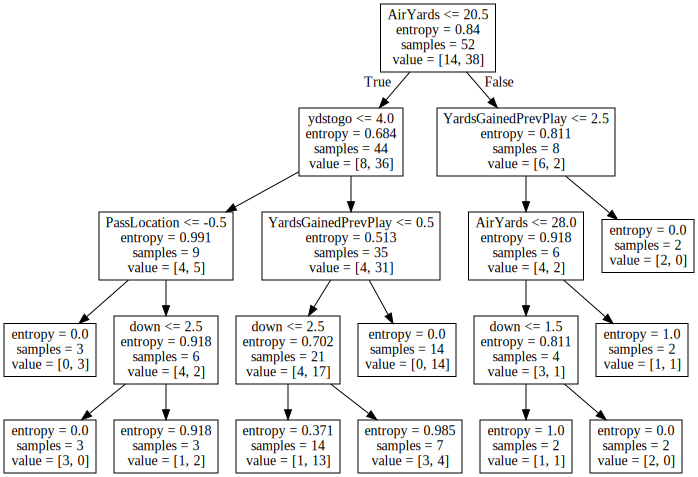

In [14]:
graph = graphviz.Source(dot_data)
graph

### Exercise 4 Save a Visualization of Decision Tree (4 points)
You can save the visualization of decision tree in a PDF file using graph.render command below. Replace '????' with the name of the file you want to use for the PDF file (without the .pdf extension).  After executing the code below with the file name, you should be able to find the file (with .pdf extension) in the same Project folder as this notebook.

In [16]:
graph.render('Visual')

'Visual.pdf'

### Exercise 5 Interpret a Decision Tree (6 points)
- (1) Find a leaf node in your decision tree that you believe gives a reliable prediction based on your training data. Describe the value of the node.
- (2) Describe the rule associated with the path from the root node to the leaf node.  When possible, describe the conditions in a way that is easy to understand.  For example, a condition of "down < 2.5" can be more easily understood (and correct, given the possible values of down are 1, 2, 3, and 4) as "down is first down or second down".  Similarly, a condition of "PassLocation < 0.5" can be more easily understood (and correct, given the possible values of PassLocation are -1, 0, and 1) as "PassLocation is Left Field or Center Field".

### Answer to Exercise 5:
- (1)The one with value [0, 14] would be a reliable prediction. It has zero times of incomplete, 14 times of complete.
- (2)IF the air yards is less than or equal to 20.5 yards, AND the yards to go is bigger than 4, AND the yards gained in previous play bigger than 0.5, we get the node we are looking at.

In [17]:
predicted_completion = clf.predict(X_test)

In [18]:
print(predicted_completion)

[1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [19]:
print(y_test)

[1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0]


In [20]:
np.mean(predicted_completion == y_test)

0.6666666666666666

In [21]:
print(metrics.classification_report(y_test, predicted_completion))

             precision    recall  f1-score   support

          0       0.33      0.20      0.25         5
          1       0.73      0.85      0.79        13

avg / total       0.62      0.67      0.64        18



In [22]:
metrics.confusion_matrix(y_test, predicted_completion)

array([[ 1,  4],
       [ 2, 11]])